<a href="https://colab.research.google.com/github/yanglinjing/dand_p7_data_wragling/blob/master/wrangle_act.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Wrangling - WeRateDogs Twitter 


# Introduction
Real-world data rarely comes clean. Using Python and its libraries, I gathered data from a variety of sources and in 3 different formats, assessed its quality and tidiness, and then cleaned it, which is called data wrangling. 

## Goal
Practice data wrangling using **WeRateDogs Twitter** data in order to create interesting and trustworthy analyses an visualizations. 

## Tools

I documented my wrangling efforts in a Jupyter Notebook, plus showcased them through analyses and visualizations using Python and its libraries (pandas, numpy, requests, json, tweepy, etc.).

## Dataset

My dataset consists of data from 3 different sources. 

### 1. Twitter Archive

The first one is the tweet archive of Twitter user **@dog_rates**, also known as **WeRateDogs**, which is a Twitter account that rates people's dogs with a humorous comment about the dog. 

WeRateDogs has over 4 million followers and has received international media coverage.

Its ratings almost always have a denominator of 10, but the numerators are always greater than 10 (e.g. 11/10, 12/10, 13/10, etc). Why? Because "they're good dogs Brent." 

### 2. Additiona information via the Twitter API

The second one is retweet count and favorite count of each tweet gathered from Twitter's API by Tweetpy Library in a Json format.

### 3.  Image Predictions File
The third is the prediction of dog images and breeds downloaded programtically by Requests Library from the neural network.


## What I did

- Examine the 3 datasets (6,787 total entries)

- Use Python to wrangle and analyze them

- Create a custom visualization to communicate observations

In [2]:
!pip install palettable

    100% |████████████████████████████████| 81kB 5.0MB/s 


In [0]:
import pandas as pd
import requests
import csv
import tweepy
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from palettable.colorbrewer.qualitative import Pastel1_7  # color

% matplotlib inline

In [4]:
# Check current working directory

!pwd

/content


In [5]:
# All the documents are stored on Google Drive.
# It requires authorisation before use them.
# This chunk of code is about authorisation.

# Mounting Google Drive locally
# https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [6]:
# Change Working Directory in Google Drive

os.chdir('gdrive/My Drive/Colab Notebooks/dand_p7_data_wragling')
!pwd

# Entire Url: '/content/gdrive/My Drive/Colab Notebooks/dand_p7_data_wragling'

/content/gdrive/My Drive/Colab Notebooks/dand_p7_data_wragling


In [0]:
# Create a new folder if it does not exist

folder_name = 'raw_data'
if not os.path.exists(folder_name):
  os.makedirs(folder_name)

In [0]:
my_color = Pastel1_7.hex_colors

# Data Gathering

## Enhanced Twitter Archive
The original data contains basic tweet data for all 5000+ of **WeRateDogs'** tweets, including rating, dog name, and dog "stage" (i.e. doggo, floofer, pupper, and puppo).

The current dataset is filtered for tweets with ratings only (there are **2356**).
 
However, some of the ratings,  dog names and dog stages probably aren't all correct.
 
Besides, some of the rating numerators are greater than the denominators - this is a unique rating system of WeRateDogs.

No data has been gathered beyond August 1st, 2017.

In [0]:
### 1st df: WeRateDogs Twitter archive

df_1_path = os.path.join(folder_name, 'twitter-archive-enhanced.csv')

with open(df_1_path, 'r') as f:
  df_1 = pd.read_csv(f)

In [44]:
df_1.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


In [0]:
df_1.shape

(2356, 17)

## Additional Data via the Twitter API
**Retweet count** and **favorite count** are two of the notable column omissions of Twitter archives.

Fortunately, this additional data can be gathered from Twitter's API. 

In [0]:
### 2nd df: 
# Each tweet's retweet count and favorite ("like") count

# Using the tweet IDs in the WeRateDogs Twitter archive, 
# query the Twitter API for each tweet's JSON data 
# using Python's Tweepy library:
# http://www.tweepy.org/

consumer_key = 'pTzzUxLTJcdNCeAHOvhUbflHX'
consumer_secret = 'bW1RvcK3vlFBxYFe9XozytZTR50hVsZmdpRCBV2zKFKUSBYEOG'
access_token = '1090182192024629249-EMhWG3aaCj1QPeMd8bHO21XPYDRQse'
access_secret = '0qWGdlA4iCQ7wFw0RK1FXC6XKHfXtzYryvil0wcyzmN3j'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit = True)
# wait_on_rate_limit = True
# Note: do not include your Twitter API keys, secrets, and tokens

In [0]:
# test

# get status object
status = api.get_status('892420643555336193') 

# get json strings from status obj
json_str = json.loads(json.dumps(status._json))

# get retweet/like counts from json strings
retweet_count = json_str['retweet_count']

In [0]:
print(retweet_count)

8302


In [0]:
df_2_list = []

# Use each id in df_1
for id in df_1['tweet_id']:
  

  # get status object
  status = api.get_status(id) 

  # get json strings from status obj
  json_str = json.loads(json.dumps(status._json))

  # get retweet/like counts from json strings
  retweet_count = json_str['retweet_count']
  favorite_count = json_str['favorite_count']

  # write to list
  df_2_list.append(f"{id} {retweet_count} {favorite_count}")


  break

df_2_list

['892420643555336193 8302 37994']

In [0]:
# Use id provided in df_1
# to retrive its retweet & favorite count, and
# temporarily store in a list

df_2_list = []

# Use each id in df_1
for id in df_1['tweet_id']:
  
  try:
    # get status object
    status = api.get_status(id) 

    # get json strings from status obj
    json_str = json.loads(json.dumps(status._json))

    # get retweet/like counts from json strings
    retweet_count = json_str['retweet_count']
    favorite_count = json_str['favorite_count']
    
    # write to list
    df_2_list.append(f"{id} {retweet_count} {favorite_count}")

  # in case there is no status obj returned
  except Exception as e:
    df_2_list.append(f"{id} Nan Nan")


In [0]:
##
# directory of df2

df_2_path = os.path.join(folder_name, 'tweet_json.txt')

In [0]:
# store each tweet's info in a file called tweet_json.txt file. 
# Each tweet's JSON data should be written to its own line. 

with open(df_2_path, "w") as f:
  for item in df_2_list:
    f.write(item + '\n')
    

In [0]:
##
# Read this .txt file line by line into a pandas DataFrame 
# with tweet ID, retweet count, and favorite count. 

df_2 = pd.read_csv(df_2_path,  sep=" ", 
                  names = ['id', 'retweet_count', 'favorite_count'])


In [47]:
df_2.head()

,id,retweet_count,favorite_count
0,892420643555336193,8302,37994
1,892177421306343426,6131,32617
2,891815181378084864,4060,24560
3,891689557279858688,8434,41319
4,891327558926688256,9147,39505


In [0]:
df_2.shape

(2356, 3)

## Image Predictions File

Every image in the WeRateDogs Twitter archive was through a neural network that can classify breeds of dogs.

(The neural network: https://www.youtube.com/watch?v=2-Ol7ZB0MmU)

The results: a table full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the **most confident prediction** (**numbered 1 to 4** since tweets can have up to four images).

In the table,
- **tweet_id** is the last part of the tweet URL after "status/" → https://twitter.com/dog_rates/status/889531135344209921
- **p1** is the algorithm's **#1 prediction** for the image in the tweet → golden retriever
- **p1_conf** is how confident the algorithm is in its #1 prediction → 95%
- **p1_dog** is whether or not the #1 prediction is a breed of dog → TRUE
- **p2** is the algorithm's **2nd most likely prediction** → Labrador retriever
- -etc.

In [48]:
### 3rd df: tweet image predictions

# The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) 
# is present in each tweet according to a neural network. 

# This file (image_predictions.tsv) is hosted on Udacity's servers and 
# should be downloaded programmatically using the Requests library 
# Requests library: http://docs.python-requests.org/en/master/


# Store the content into response in working memory

url_3 = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url_3)

response
# <Response [200]>: success

<Response [200]>

In [0]:
# folder name / file name (shown in url_2):
# 'raw_data/image-predictions.tsv'

df_3_path = os.path.join(folder_name, url_3.split('/')[-1])

In [0]:
# put the content of response into f
with open (df_3_path, mode='wb') as f:
  f.write(response.content)
  
# ensure the new file has been built
# os.listdir(folder_name)

In [117]:
df_3 = pd.read_csv(df_3_path, sep='\t')

df_3.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [51]:
df_3.shape

(2075, 12)

# Data Cleaning


In [0]:
df_1_copy = df_1
df_2_copy = df_2
df_3_copy = df_3

## Table 1: Enhanced Twitter Archive



###  Quality issues
Completeness:


-  in_reply_to_status_id: 78 out of 2356 is non-null
- in_reply_to_user_id: 78 out of 2356 is non-null
- retweeted_status_id: 181 out of 2356 is non-null
- retweeted_status_user_id:  181 out of 2356 is non-null
- retweeted_status_timestamp:  181 out of 2356 is non-null
- name: string 'None' should be replaced by Null


Validity:

- rating_denominator contains invalid values (e.g. denominator = 0)
- expanded_url just includeds incompleted url, which contains "https://twitter.com/dog_rates/status/" plus part of tweet_id


Accuracy:

- rating_numberator contains extremely large values (e.g. 1776 when denominator = 10)

Consistency: 

- source: the long name with HTML tag could be shorten.


Data Types:

- tweet_id: int -> obj
-  timestamp: obj -> datetime
-  in_reply_to_status_id: float -> object
- in_reply_to_user_id: float -> object
- retweeted_status_id: float -> object
- retweeted_status_user_id: float -> object

### Tidiness Issues 

- doggo	/ floofer	/ pupper /	puppo: could be combined into 1 column as categorical data.

In [0]:
df_1.info()

# in_reply & retweeted have too much missing values

In [0]:
df_1.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
355,830956169170665475,NaN,NaN,2017-02-13 01:46:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Reggie. He hates puns. 12/10 ligh...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/830956169...,12,10,Reggie,None,None,None,None
176,857746408056729600,NaN,NaN,2017-04-28 00:00:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Thor. He doesn't have finals because he's...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/857746408...,13,10,Thor,None,None,None,None
2249,667861340749471744,NaN,NaN,2015-11-21 00:25:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Shotokon Macadamia mix named Cheryl....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667861340...,9,10,a,None,None,None,None


In [0]:
df_1.duplicated().sum()

# no duplicated rows

0

In [0]:
df_1['doggo'].value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [0]:
df_1['floofer'].value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [0]:
df_1['pupper'].value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [0]:
df_1['puppo'].value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [0]:
df_1['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [0]:
df_1[df_1['rating_denominator'] !=10]

# index = 313 (denominator = 0) should be deleted.

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None


In [0]:
df_1.query('rating_denominator == 10')['rating_numerator'].describe()

# check the data max = 1776
# min = 0 is correct

count    2333.000000
mean       12.237462
std        41.022472
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

In [0]:
df_1_copy.query('rating_denominator == 10').sort_values('rating_numerator', ascending=False)

# some numerators are extremely large: 75 - 1776

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277...,1776,10,Atticus,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
2074,670842764863651840,NaN,NaN,2015-11-29 05:52:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After so many requests... here you go.\n\nGood...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670842764...,420,10,None,None,None,None,None
290,838150277551247360,8.381455e+17,2.195506e+07,2017-03-04 22:12:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@markhoppus 182/10,NaN,NaN,NaN,NaN,182,10,None,None,None,None,None
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: This is Logan, the Chow who liv...",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034...,27,10,Sophie,None,None,pupper,None
1712,680494726643068929,NaN,NaN,2015-12-25 21:06:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have uncovered an entire battalion of ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680494726...,26,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None


In [0]:
df_1['source'].value_counts()

# <a> tag could be deleted

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [0]:
df_1[:1]['expanded_urls']

# incompleted url, just contains "https://twitter.com/dog_rates/status/" plus part of tweet_id

0    https://twitter.com/dog_rates/status/892420643...
Name: expanded_urls, dtype: object

### Cleaning Table_1

The following columns contains few valid values, which could not contribute to analysis. Thus, they are deleted.

- in_reply_to_status_id: 78 out of 2356 is non-null
- in_reply_to_user_id: 78 out of 2356 is non-null
- retweeted_status_id: 181 out of 2356 is non-null
- retweeted_status_user_id: 181 out of 2356 is non-null
- retweeted_status_timestamp: 181 out of 2356 is non-null

In [0]:
df_1_copy = df_1_copy.drop(columns = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'])

- In the column of name, the string 'None' should be replaced by Null.

In [0]:
df_1_copy['name'].replace('None', np.NaN, inplace = True)

- The column of expanded_url just includeds incompleted url, which equals to "https://twitter.com/dog_rates/status/" plus part of tweet_id. This could not contribute to analysis, so it is deleted.

In [0]:
df_1_copy = df_1_copy.drop(columns = ['expanded_urls'])

- In the column of source, the long name with HTML tag could be shorten.

In [0]:
df_1_copy.replace({'source': {
    '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>': 'Twitter for iPhone',
    '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>': 'Vine',
    '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>': 'Twitter Web Client',
    '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>': 'TweetDeck'
}}, inplace = True)

- Change the data type of tweet_id to object.

In [0]:
df_1_copy['tweet_id'] = df_1_copy['tweet_id'].astype(str)

- Change the data type of timestamp to datetime.

In [0]:
df_1_copy['timestamp'] = pd.to_datetime(df_1_copy['timestamp'])

- doggo / floofer / pupper / puppo: could be combined into 1 column as categorical data.

In [0]:
dog_stages = ['doggo', 'floofer', 'pupper', 'puppo']

for i, row in df_1_copy.iterrows():
    ifor_val = ''
    for dog_stage in dog_stages:
      if row[dog_stage] != 'None':
        ifor_val += dog_stage
    df_1_copy.at[i,'stage'] = ifor_val

In [58]:
df_1_copy['stage'].value_counts()

# a few dogs were marked as in 2 stages.

                1976
pupper           245
doggo             83
puppo             29
doggopupper       12
floofer            9
doggofloofer       1
doggopuppo         1
Name: stage, dtype: int64

A new quality issue rises:
- a few dogs have been marked in 2 stages.

Since we could not judge which exact stage they are in, the stage of these doges should be changed to none.

In [0]:
df_1_copy.replace(
    {'stage': {
        '': np.NaN,
        'doggopupper': np.NaN,
        'doggopuppo': np.NaN,
        'doggofloofer': np.NaN
    }}, 
    inplace = True)

In [0]:
df_1_copy.drop(columns = ['doggo', 'floofer', 'pupper', 'puppo'], 
               inplace = True)

In [61]:
df_1_copy.sample(3)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,stage
466,817171292965273600,2017-01-06 00:49:53 +0000,Twitter for iPhone,This is Tebow. He kindly requests that you put...,13,10,Tebow,NaN
231,847971574464610304,2017-04-01 00:39:12 +0000,Twitter for iPhone,RT @basic_vacek_: I love my new mug easy 13/10...,13,10,NaN,NaN
494,813187593374461952,2016-12-26 01:00:05 +0000,Twitter for iPhone,We only rate dogs. Please don't send in other ...,13,10,NaN,NaN


## Table 2: Additional Infomation (Retweet & Favourate)

### Quality issues

Completeness:

- retweet & favouriate count: "Nan" should be replaced by Null.
- retweet & favouriate count: 16 missing values

Data Type:
 - retweet & favouriate count: obj -> int

In [0]:
df_2_copy.info()

### Cleaning Table_2

- Replace missing values by Null.

In [0]:
# Replace str 'Nan' with Null

df_2_copy.replace('Nan', np.NaN, inplace = True)

In [90]:
df_2_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 3 columns):
id                2356 non-null object
retweet_count     2340 non-null object
favorite_count    2340 non-null object
dtypes: object(3)
memory usage: 55.3+ KB


In [91]:
df_2_copy.sample(5)

,id,retweet_count,favorite_count
1961,673359818736984064,690,1480
569,801958328846974976,1871,8246
145,863553081350529029,4210,15301
910,757611664640446465,1203,4806
829,768909767477751808,2914,0


## Table 3: Image Predictions

### Quality Issues

Data Types:

- tweet_id: int -> obj

### Tidiness Issues:

- the colum names could be more clear.

In [119]:
df_3_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [120]:
df_3_copy.sample(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1932,859196978902773760,https://pbs.twimg.com/ext_tw_video_thumb/85919...,1,Angora,0.224218,False,malamute,0.216163,True,Persian_cat,0.128383,False
1328,757400162377592832,https://pbs.twimg.com/media/CoLTbbzXYAElNM6.jpg,1,seat_belt,0.523926,False,golden_retriever,0.087800,True,Tibetan_mastiff,0.075127,True
519,676496375194980353,https://pbs.twimg.com/media/CWNl3S9WcAARN34.jpg,1,pug,0.985387,True,Norwegian_elkhound,0.004417,True,French_bulldog,0.003893,True


In [0]:
df_3.duplicated().sum()

0

In [0]:
df_3['p1'].value_counts()

In [107]:
df_3['img_num'].value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

### Cleaning Table_3:

In [0]:
#df_3_copy.drop(columns = ['jpg_url', 'img_num'], inplace = True)

- Change data type of tweet_id to object.

In [0]:
df_3_copy['tweet_id'] = df_3_copy['tweet_id'].astype(str)

- Change column names.

In [0]:
df_3_copy.rename(columns = {
    'p1': 'prediction_1',
    'p1_dog': 'p1_breed_dog',
    'p2': 'prediction_2',
    'p2_dog': 'p2_breed_dog',
    'p3': 'prediction_3',
    'p3_dog': 'p3_breed_dog',
    'tweet_id': 'tweet_id_3'
}, inplace = True)

In [123]:
df_3_copy.sample(3)

,tweet_id_3,jpg_url,img_num,prediction_1,p1_conf,p1_breed_dog,prediction_2,p2_conf,p2_breed_dog,prediction_3,p3_conf,p3_breed_dog
749,687818504314159109,https://pbs.twimg.com/media/CYufR8_WQAAWCqo.jpg,1,Lakeland_terrier,0.873029,True,soft-coated_wheaten_terrier,0.060924,True,toy_poodle,0.017031,True
687,684122891630342144,https://pbs.twimg.com/media/CX5-HslWQAIiXKB.jpg,1,cheetah,0.822193,False,Arabian_camel,0.046976,False,jaguar,0.025785,False
504,675888385639251968,https://pbs.twimg.com/media/CWE85snWIAEG5ES.jpg,1,West_Highland_white_terrier,0.672117,True,Old_English_sheepdog,0.146147,True,komondor,0.023141,True


## Combining the 3 tables

- Join 3 tables

In [0]:
df_joint = pd.merge(df_1_copy,
                   df_2_copy,
                   left_on = 'tweet_id',
                   right_on = 'id',
                   how = 'left'
                   )

In [0]:
df_joint = pd.merge(df_joint,
                   df_3_copy,
                   left_on = 'tweet_id',
                   right_on = 'tweet_id_3',
                   how = 'left'
                   )

In [0]:
df_joint.drop(columns={'id', 'tweet_id_3'}, inplace = True)

- Drop the row rating_denominator = 0

In [127]:
df_joint.query('rating_denominator == 0')

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,stage,retweet_count,favorite_count,...,img_num,prediction_1,p1_conf,p1_breed_dog,prediction_2,p2_conf,p2_breed_dog,prediction_3,p3_conf,p3_breed_dog
313,835246439529840640,2017-02-24 21:54:03,Twitter for iPhone,@jonnysun @Lin_Manuel ok jomny I know you're e...,960,0,NaN,NaN,78,2191,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
df_joint.drop(index = 313, axis = 0, inplace = True)

In [134]:
df_joint.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2355 entries, 0 to 2355
Data columns (total 21 columns):
tweet_id              2355 non-null object
timestamp             2355 non-null datetime64[ns]
source                2355 non-null object
text                  2355 non-null object
rating_numerator      2355 non-null int64
rating_denominator    2355 non-null int64
name                  1611 non-null object
stage                 366 non-null object
retweet_count         2339 non-null object
favorite_count        2339 non-null object
jpg_url               2075 non-null object
img_num               2075 non-null float64
prediction_1          2075 non-null object
p1_conf               2075 non-null float64
p1_breed_dog          2075 non-null object
prediction_2          2075 non-null object
p2_conf               2075 non-null float64
p2_breed_dog          2075 non-null object
prediction_3          2075 non-null object
p3_conf               2075 non-null float64
p3_breed_dog          20

In [135]:
df_joint.sample(5)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,stage,retweet_count,favorite_count,...,img_num,prediction_1,p1_conf,p1_breed_dog,prediction_2,p2_conf,p2_breed_dog,prediction_3,p3_conf,p3_breed_dog
411,823269594223824897,2017-01-22 20:42:21,Twitter for iPhone,RT @dog_rates: We only rate dogs. Please don't...,11,10,NaN,NaN,10692,0,...,1.0,Samoyed,0.585441,True,Pomeranian,0.193654,True,Arctic_fox,0.071648,False
1441,696877980375769088,2016-02-09 02:07:12,Twitter for iPhone,This is Misty. She's in a predicament. Not sur...,9,10,Misty,pupper,754,2548,...,1.0,space_heater,0.206876,False,spatula,0.123450,False,vacuum,0.119218,False
392,826115272272650244,2017-01-30 17:10:04,Twitter for iPhone,This is Ike. He's demonstrating the pupmost re...,13,10,Ike,NaN,3400,16539,...,1.0,tennis_ball,0.997071,False,golden_retriever,0.002331,True,kuvasz,0.000283,True
736,780931614150983680,2016-09-28 00:46:20,Twitter for iPhone,I want to finally rate this iconic puppo who t...,13,10,NaN,puppo,7999,23056,...,1.0,padlock,0.731564,False,necklace,0.065462,False,chain,0.036469,False
2287,667177989038297088,2015-11-19 03:10:02,Twitter for iPhone,This is a Dasani Kingfisher from Maine. His na...,8,10,a,NaN,55,192,...,1.0,vizsla,0.259249,True,Chesapeake_Bay_retriever,0.176293,True,Weimaraner,0.112369,True


## Write to CSV File

In [0]:
# write to csv file

df_joint.to_csv('twitter_archive_master.csv', 
                index = False)


## Change Data Type

In [0]:
df = pd.read_csv('twitter_archive_master.csv')

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2355 entries, 0 to 2354
Data columns (total 21 columns):
tweet_id              2355 non-null int64
timestamp             2355 non-null datetime64[ns]
source                2355 non-null object
text                  2355 non-null object
rating_numerator      2355 non-null int64
rating_denominator    2355 non-null int64
name                  1611 non-null object
stage                 366 non-null object
retweet_count         2339 non-null float64
favorite_count        2339 non-null float64
jpg_url               2075 non-null object
img_num               2075 non-null float64
prediction_1          2075 non-null object
p1_conf               2075 non-null float64
p1_breed_dog          2075 non-null object
prediction_2          2075 non-null object
p2_conf               2075 non-null float64
p2_breed_dog          2075 non-null object
prediction_3          2075 non-null object
p3_conf               2075 non-null float64
p3_breed_dog          2

- timestamp: obj -> datetime

In [0]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Analysing Data

## 1. Dog Ratings

Since there are various rating denominators (although most of them are 10), the rating of dogs is calculated by diving the numerator by the denominator.

From the sorted raw data in the Data Cleaning section and the calculation above, it can be seen that there are 10 rows have their ratings larger than 1.7, including most outliers.

After cutting off these 10 rows, it shows that the ratings of dogs are left-skewed distributed, with the mean of 1.07 and the median of 1.10. Besides, 75% of the dogs are rated equal to or more than 100%. Thus, it can be found that most dogs are considered to be better than perfect.

In [0]:
# calculate

df['ratings'] = df['rating_numerator'] / df['rating_denominator']

In [0]:
df.query('ratings < 2')['ratings'].describe()

# after cutting the 10 outliers larger than 2
# max = 1.7

count    2345.000000
mean        1.069406
std         0.219355
min         0.000000
25%         1.000000
50%         1.100000
75%         1.200000
max         1.700000
Name: ratings, dtype: float64

In [0]:
df.query('ratings > 2')['ratings'].count()

# only 10 rows have their ratings > 2

10

In [0]:
# cut outliers

ratings = df.query('ratings <= 1.7')['ratings']

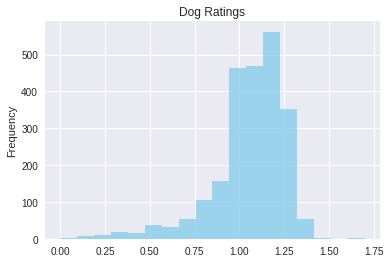

In [175]:
# draw

ratings.plot(kind = 'hist',
            color = 'skyblue',
            alpha = 0.8,
            bins = 18,
            title = 'Dog Ratings')

## 2. Source of Tweet

From the pie chart, it presents that the dominate source is from iPhone, which is 94.3%. Only a few people use Vine (3.9%), Website (1.4%) and TweetDect (0.5%) to browse WeRateDogs Tweet.

In [0]:
df["source"].value_counts()

Twitter for iPhone    2220
Vine                    91
Twitter Web Client      33
TweetDeck               11
Name: source, dtype: int64

In [0]:
# set labels & values for pie

pie_names = ['Twitter for iPhone',
             'Twitter Web Client',
             'Vine',
             'TweetDeck' ]

pie_size = []

for pie_name in pie_names:
  size = df.query('source == @pie_name')['source'].count()
  pie_size.append(size)
  

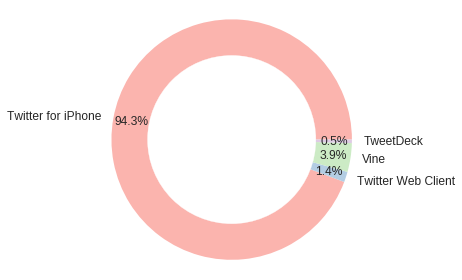

In [27]:
# draw pie chart

fig1, ax1 = plt.subplots()

ax1.pie(pie_size, 
        labels = pie_names, 
        colors = my_color, 
        textprops = {'fontsize': 12},
        autopct = '%1.1f%%',
        pctdistance = 0.85)

# draw circle
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)


# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()


## 3. **Relationship between** Retweet and Favourite

The count of retweet and favourite are highly positively correlated ( *r * = 0.797). Thus, we could say that the more people like a tweet, the more they retweet it.

Text(0.5, 1.0, 'Retweet v.s. Favourite')

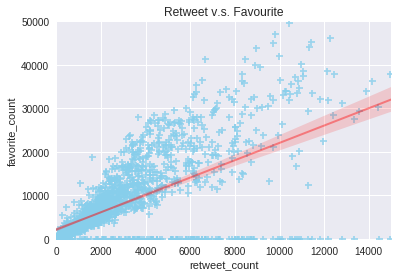

In [170]:
# draw scatter plot

sns.regplot(x=df["retweet_count"], 
            y=df["favorite_count"], 
            line_kws={"color":"r","alpha":0.4,"lw":2},
            marker="+",
            color = 'skyblue')

# control x and y limits
sns.plt.ylim(0, 50000)
sns.plt.xlim(0, 15000)
sns.plt.title('Retweet v.s. Favourite')

#sns.plt.show()

In [0]:
df[['retweet_count', 'favorite_count']].corr()

,retweet_count,favorite_count
retweet_count,1.000000,0.797103
favorite_count,0.797103,1.000000


## 4. Breeds

The top 15 predicted dogs are shown in the plot.

It can be seen that **golden retriever** is the No.1 predicted dog, which has been predicted 150 times with high confidence. The confidence of predicting it is left skewed, with the median of 0.78 and mean of 0.72.

The second most predicted dog is **Labrador_retriever** (100 times), the high confidence of which is also left skewed with the median of 0.71 and mean of 0.67.

In [0]:
df['prediction_1'].value_counts()

In [0]:
# Store value_counts and dog_types into df_predict
df_predict = df['prediction_1'].value_counts().to_frame()

# rename columns of df_predict
df_predict.rename(columns = {'prediction_1': 'counts'}, inplace = True)

# only keep dogs that appear 20+ 
df_predict = df_predict.query('counts > 20')

# Reorder it following the values:
df_predict = df_predict.sort_values(by = 'counts')

# set range
my_range = range(1, df_predict.shape[0] + 1)

Text(0, 0.5, 'Dog Types')

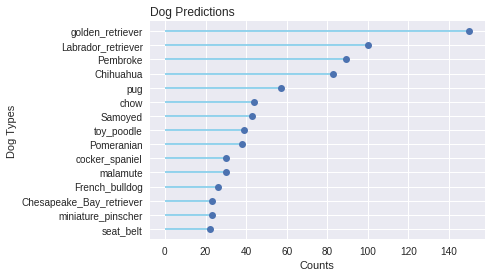

In [13]:
# Draw lolipop plot

plt.hlines(y=my_range, xmin=0, xmax=df_predict['counts'], color='skyblue')
plt.plot(df_predict['counts'], my_range, "o")
 
# Add titles and axis names
plt.yticks(my_range, df_predict.index)

plt.title("Dog Predictions", loc='left')
plt.xlabel('Counts')
plt.ylabel('Dog Types')


In [14]:
golden_retriever = df.query('prediction_1 == "golden_retriever"')['p1_conf']

golden_retriever.describe()

count    150.000000
mean       0.723555
std        0.223237
min        0.140394
25%        0.601533
50%        0.776138
75%        0.907470
max        0.993830
Name: p1_conf, dtype: float64

In [15]:
Labrador_retriever = df.query('prediction_1 == "Labrador_retriever"')['p1_conf']

Labrador_retriever.describe()

count    100.000000
mean       0.666523
std        0.236668
min        0.195835
25%        0.460494
50%        0.719996
75%        0.868671
max        0.999885
Name: p1_conf, dtype: float64

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


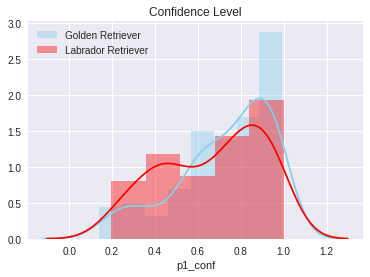

In [171]:
sns.distplot( golden_retriever , color="skyblue", label="Golden Retriever")
sns.distplot( Labrador_retriever , color="red", label="Labrador Retriever")

sns.plt.title('Confidence Level')

sns.plt.legend()

## 5. Dog Stages

Only 366 out of 2355 dogs have their stages presented in the dataset. The most common stage is pupper (245), followed by doggo (83) among the dogs whose stage has been presented.

In [0]:
df.info()

In [9]:
df['stage'].value_counts()

pupper     245
doggo       83
puppo       29
floofer      9
Name: stage, dtype: int64

In [14]:
stages = df['stage'].value_counts().to_frame()
stages

,stage
pupper,245
doggo,83
puppo,29
floofer,9


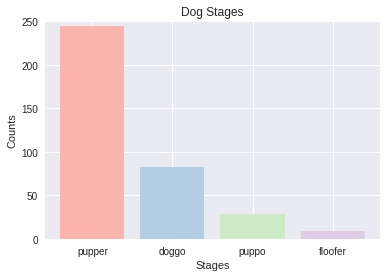

In [24]:
# Create bars and choose color
plt.bar(stages.index, stages['stage'], color = my_color)
 
# Limits for the Y axis
plt.ylim(0,250)

# Add title and axis names
plt.title('Dog Stages')
plt.xlabel('Stages')
plt.ylabel('Counts')
 
# Show graphic
plt.show()


## 6. Post Tweet Day

From Monday to Sunday, the number of posted tweet decreases. WeRateDogs followers may expect to see more new tweets on Monday.

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2355 entries, 0 to 2354
Data columns (total 20 columns):
tweet_id              2355 non-null int64
timestamp             2355 non-null object
source                2355 non-null object
text                  2355 non-null object
rating_numerator      2355 non-null int64
rating_denominator    2355 non-null int64
name                  1611 non-null object
stage                 366 non-null object
retweet_count         2339 non-null float64
favorite_count        2339 non-null float64
prediction_1          2075 non-null object
p1_conf               2075 non-null float64
p1_breed_dog          2075 non-null object
prediction_2          2075 non-null object
p2_conf               2075 non-null float64
p2_breed_dog          2075 non-null object
prediction_3          2075 non-null object
p3_conf               2075 non-null float64
p3_breed_dog          2075 non-null object
ratings               2355 non-null float64
dtypes: float64(6), int64(3), o

In [0]:
df['weekday'] = df['timestamp'].dt.dayofweek

In [145]:
df['weekday'].value_counts()
# Monday=0, Sunday=6

0    384
1    356
2    354
4    332
3    326
5    309
6    294
Name: weekday, dtype: int64

In [166]:
weekdays = df['weekday'].value_counts().to_frame()

weekdays.rename(columns = {'weekday': 'Counts'}, inplace = True)

weekdays['Weekday'] = ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday','Saturday','Sunday']

#weekdays.set_index('Weekday', inplace = True)
weekdays

,Counts,Weekday
0,384,Monday
1,356,Tuesday
2,354,Wednesday
4,332,Thursday
3,326,Friday
5,309,Saturday
6,294,Sunday


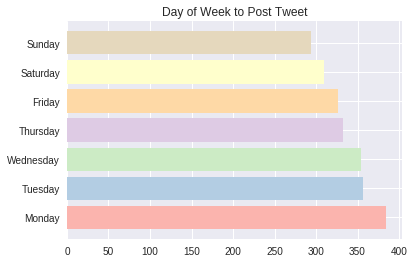

In [173]:
# draw

y_pos = np.arange(weekdays['Weekday'].count())
 
# Create horizontal bars
plt.barh(y_pos, weekdays['Counts'], color=my_color)
 
# Create names on the y-axis
plt.yticks(y_pos, weekdays['Weekday'])
 
# Show graphic
plt.title('Day of Week to Post Tweet')
plt.show()
